In [4]:
# pwd = "/Users/youtao/code"
pwd = "/scratch/ty296"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np
import seaborn as sns

/scratch/ty296


In [5]:
from read_hdf5_func import *

In [6]:
from datetime import date
hdf5_combined_data_path = "/scratch/ty296/hdf5_data_combined"
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
# combined_sv_filename = os.path.join(hdf5_combined_data_path, f"sv_combined_{p_fixed_name}{p_fixed_value}_{date.today()}.h5")
combined_sv_filename = "/scratch/ty296/hdf5_data_combined/sv_combined_p_ctrl0.4_2025-10-19.h5"
# combine(combined_sv_filename, p_fixed_name, p_fixed_value, eps_value=0.0)


In [ ]:
def fixed_L_threshold_comparison_plot(save_folder: str, L: int, n: int, p_fixed_name: str, p_fixed_value: float, threshold_range: tuple):
    """
    Plot the comparison of the entropy for different thresholds
    """
    
    # Read from csv files
    csv_paths = glob.glob(os.path.join(save_folder, f's{n}_threshold*_{p_fixed_name}{p_fixed_value}.csv'))
    
    # Organize data by threshold values
    plot_data = {}
    import re
    
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        # Find data specific to L
        df_L = df[df['L'] == L]
        
        if len(df_L) == 0:
            continue
            
        # Extract threshold from csv_path filename
        threshold_match = re.search(r'threshold([\d\.e\-\+]+)', csv_path)
        if threshold_match:
            threshold_str = threshold_match.group(1)
            threshold_val = float(threshold_str)
        else:
            continue
            
        # Sort by p_proj and get corresponding values
        sorted_indices = np.argsort(df_L['p_proj'])
        plot_data[threshold_val] = {
            'p_proj': df_L['p_proj'].iloc[sorted_indices].values,
            'mean': df_L['mean'].iloc[sorted_indices].values,
            'sem': df_L['sem'].iloc[sorted_indices].values,
            'variance': df_L['variance'].iloc[sorted_indices].values,
            'se_var': df_L['se_var'].iloc[sorted_indices].values
        }

    # Create plots with same formatting as plot_from_csv
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted threshold values and create color map
    threshold_values = sorted(plot_data.keys())[threshold_range[0]:threshold_range[1]]
    n_thresholds = len(threshold_values)
    colors = sns.color_palette("Blues", n_colors=n_thresholds)

    # Plot 1: p_proj vs mean ± sem
    for i, threshold in enumerate(threshold_values):
        data = plot_data[threshold]
        ax1.errorbar(data['p_proj'], data['mean'], yerr=data['sem'], 
                    label=f'threshold={threshold:.1e}', marker='o', capsize=5, capthick=2, color=colors[n_thresholds-1-i])

        ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'],
                    label=f'threshold={threshold:.1e}', marker='s', capsize=5, capthick=2, color=colors[n_thresholds-1-i])

    ax1.set_xlabel('p_proj')
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title(f'Mean Entropy vs p_proj for L={L}')
    ax1.legend()
    # ax1.set_xlim(0.2, 1.0)
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('p_proj')
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title(f'Variance vs p_proj for L={L}')
    # ax2.legend()
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax2.set_xlim(0.2, 1.0)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_folder}/s{n}_threshold_comparison_{L}.png')
    plt.show()
    # plt.close()
    print(f'Threshold comparison for L={L} saved to {save_folder}/s{n}_threshold_comparison_{L}.png')

def plot_from_csv(save_folder, n, threshold: float):
    """
    Plot p_proj vs mean±SEM and p_proj vs variance±SEVAR from CSV file
    CSV should have columns: L, p_ctrl, p_proj, mean, sem, variance, se_var
    """
    # Read CSV data
    csv_path = os.path.join(save_folder, f's{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.csv')
    df = pd.read_csv(csv_path)
    
    # Organize data by L values
    plot_data = {}
    for _, row in df.iterrows():
        L = row['L']
        if L not in plot_data:
            plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
    
    # Organize data by L values
    plot_data = {}
    for _, row in df.iterrows():
        L = row['L']
        if L not in plot_data:
            plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
        
        plot_data[L]['p_proj'].append(row['p_proj'])
        plot_data[L]['mean'].append(row['mean'])
        plot_data[L]['sem'].append(row['sem'])
        plot_data[L]['variance'].append(row['variance'])
        plot_data[L]['se_var'].append(row['se_var'])

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted L values and create color map
    L_values = sorted(plot_data.keys())[0:4]
    n_L = len(L_values)
    
    # Create increasingly deeper shades of blue proportional to L value
    # Smaller L = very light blue, larger L = darker blue
    colors = sns.color_palette("Blues", n_colors=n_L)

    # Plot 1: p_proj vs mean ± sem
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by p_proj for cleaner lines
        sorted_indices = np.argsort(data['p_proj'])
        p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
        mean_sorted = np.array(data['mean'])[sorted_indices]
        sem_sorted = np.array(data['sem'])[sorted_indices]
        
        ax1.errorbar(p_proj_sorted, mean_sorted, yerr=sem_sorted, 
                    label=f'L={L}', marker='o', capsize=5, capthick=2, color=colors[i])

    ax1.set_xlabel('p_proj')
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title('Mean Entropy vs p_proj for Different L')
    ax1.legend()
    ax1.set_xlim(0.5, 1.0)
    ax1.grid(True, alpha=0.3)

    # Plot 2: p_proj vs variance ± se_var
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by p_proj for cleaner lines
        sorted_indices = np.argsort(data['p_proj'])
        p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
        variance_sorted = np.array(data['variance'])[sorted_indices]
        se_var_sorted = np.array(data['se_var'])[sorted_indices]
        
        ax2.errorbar(p_proj_sorted, variance_sorted, yerr=se_var_sorted, 
                    label=f'L={L}', marker='s', capsize=5, capthick=2, color=colors[i])

    ax2.set_xlabel('p_proj')
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title('Variance vs p_proj for Different L')
    ax2.legend()
    ax2.set_xlim(0.5, 1.0)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
    plt.close()
    print(f'threshold {threshold} saved to {save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
    # plt.show()

In [8]:
# n = 0
# from read_hdf5_func import h5_to_csv
# for threshold_val in np.linspace(1e-15, 1e-14, 10):
#     h5_to_csv(combined_sv_filename, n, threshold_val, p_fixed_name, p_fixed_value)

In [9]:

# save_folder = "/scratch/ty296/plots"
# for threshold_val in np.logspace(-15, -5, 10):
#     plot_from_csv(save_folder, n, threshold_val)

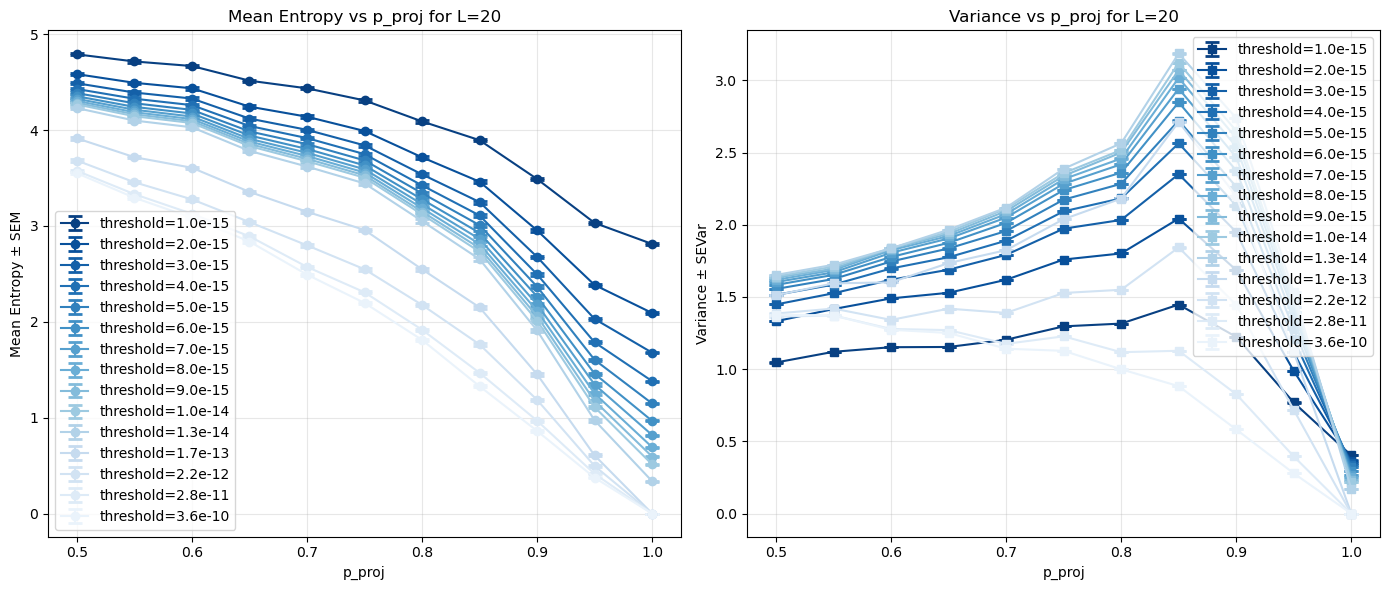

Threshold comparison for L=20 saved to /scratch/ty296/plots/s0_threshold_comparison_20.png


In [10]:
L_target = 20
n_thresholds = 15
i = 0
n = 0
fixed_L_threshold_comparison_plot("/scratch/ty296/plots", L_target, n, p_fixed_name, p_fixed_value, (i, i+n_thresholds))

In [10]:
# plot distributions
L_target = 20
threshold_val = 1e-14
min_sv_dict, maxbond_dict, entropy_dict = distribution_dict(combined_sv_filename, L_target, threshold_val)

INVALID MIN_SV (skipping): seed=0
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=1
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=10
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=100
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=101
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=102
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=103
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=104
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=105
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVALID MIN_SV (skipping): seed=106
  Parameters: L=20, p_ctrl=0.4, p_proj=0.55
  min_sv value: 0.0
INVAL

In [17]:
s0_dict = total_s0_dict(combined_sv_filename, threshold_val)

In [21]:
np.savetxt('s0_dict_20_0.4_0.65.txt', s0_dict[(20,0.4,0.65)])

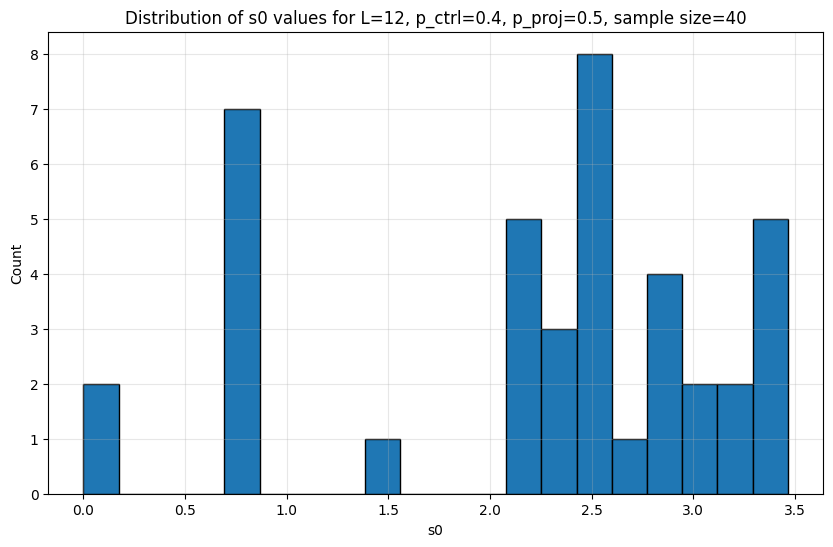

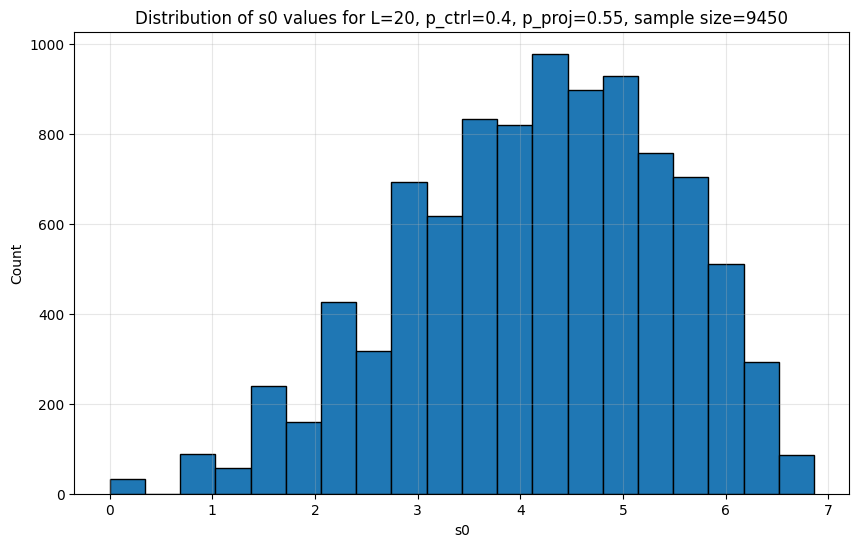

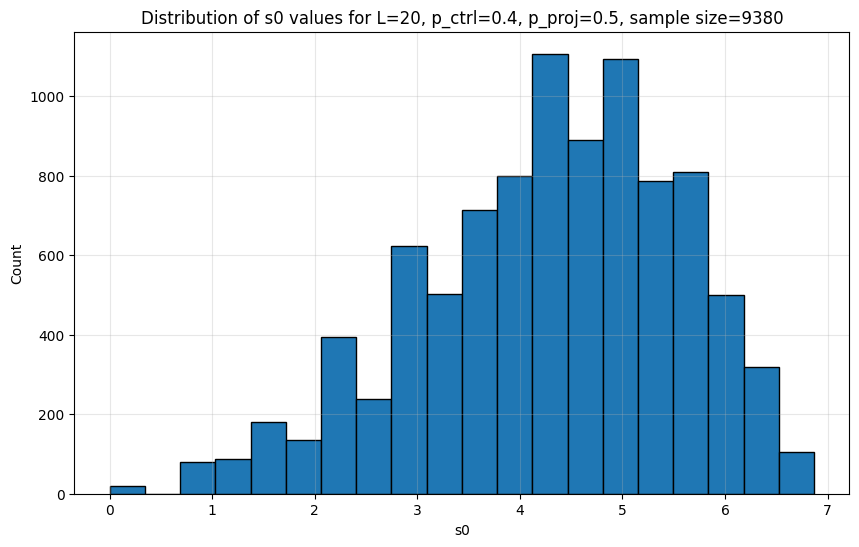

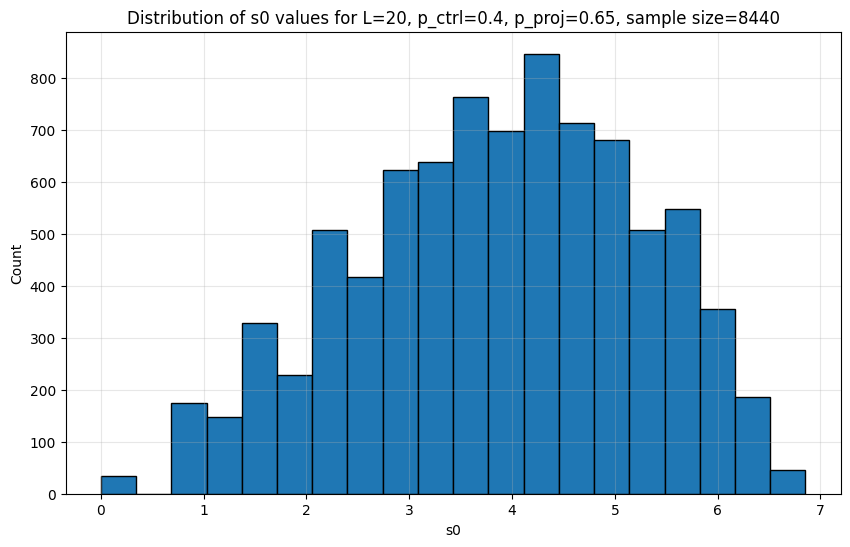

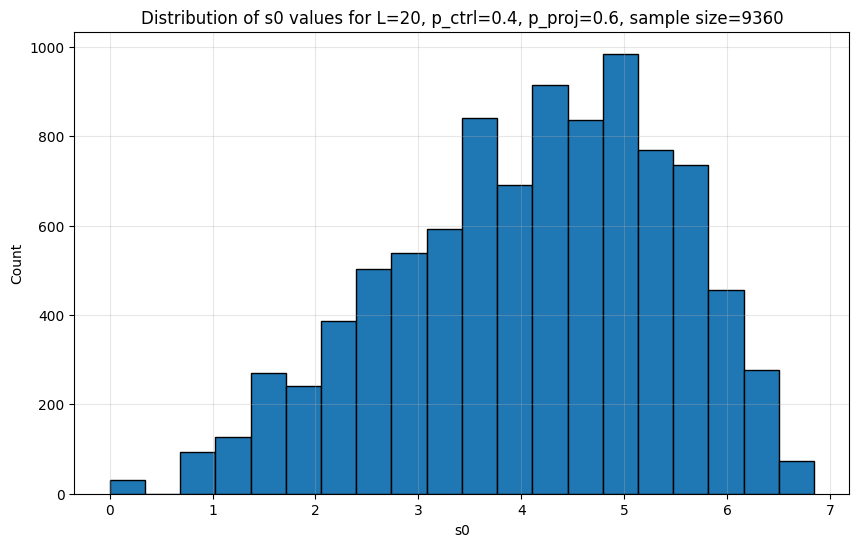

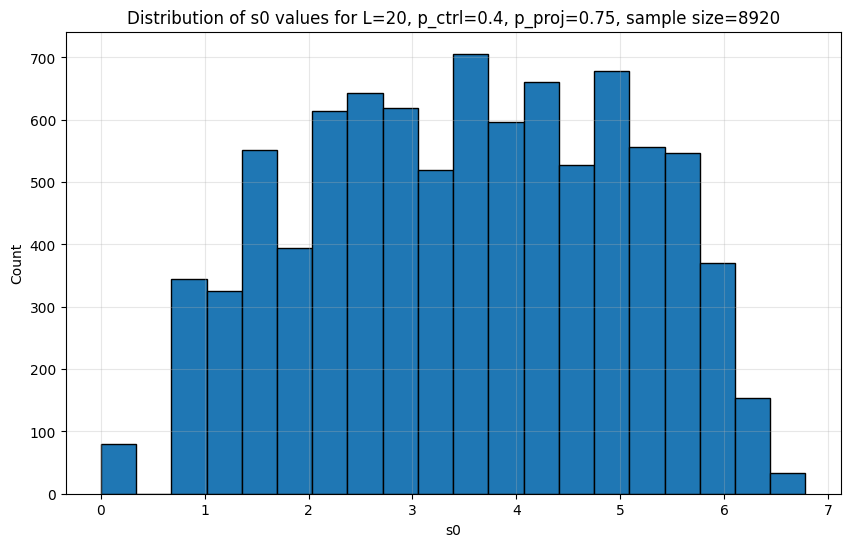

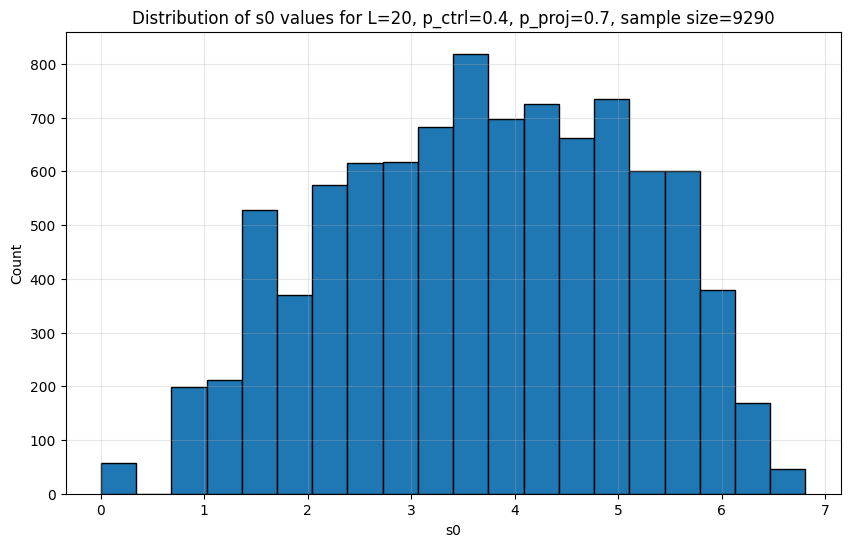

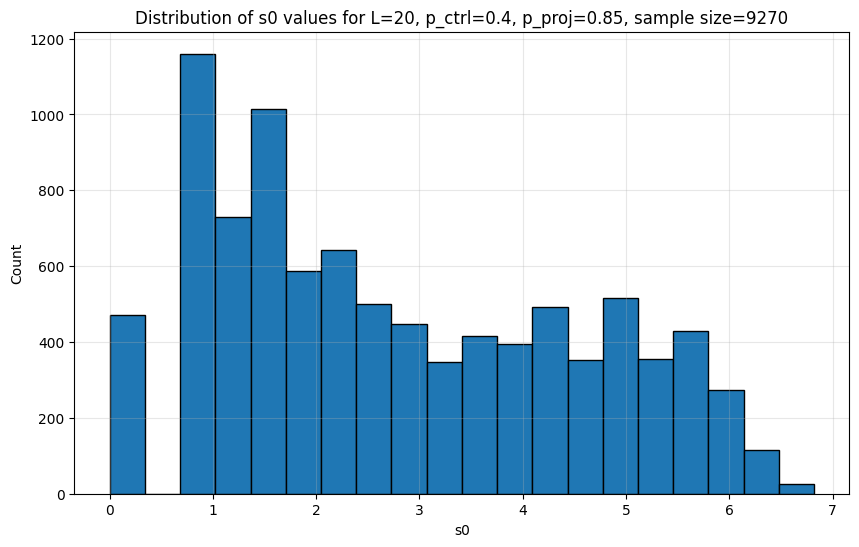

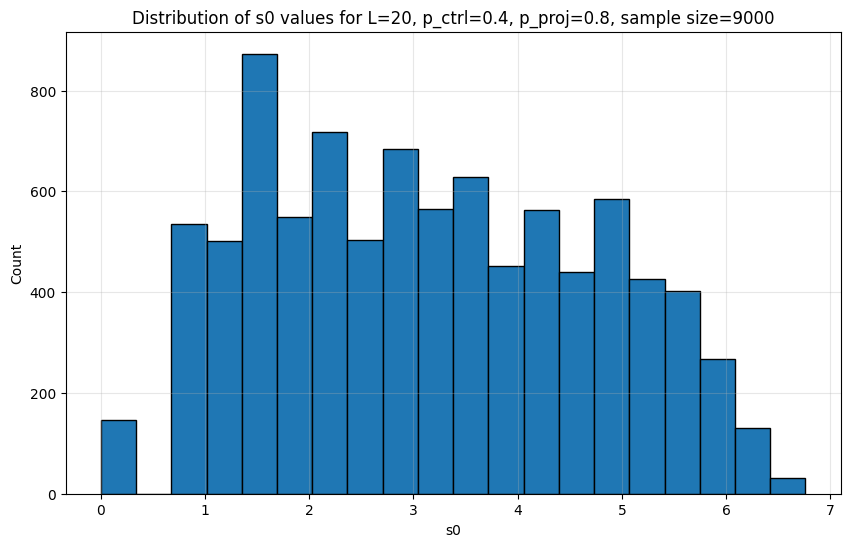

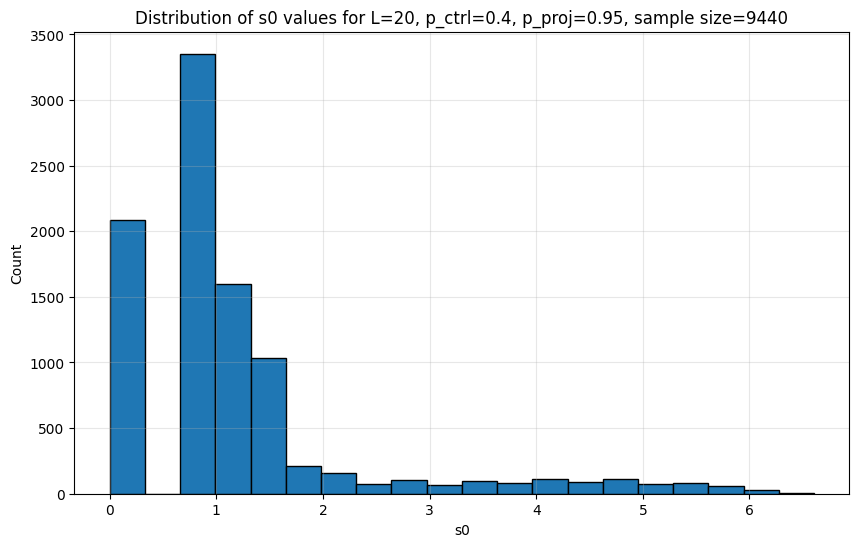

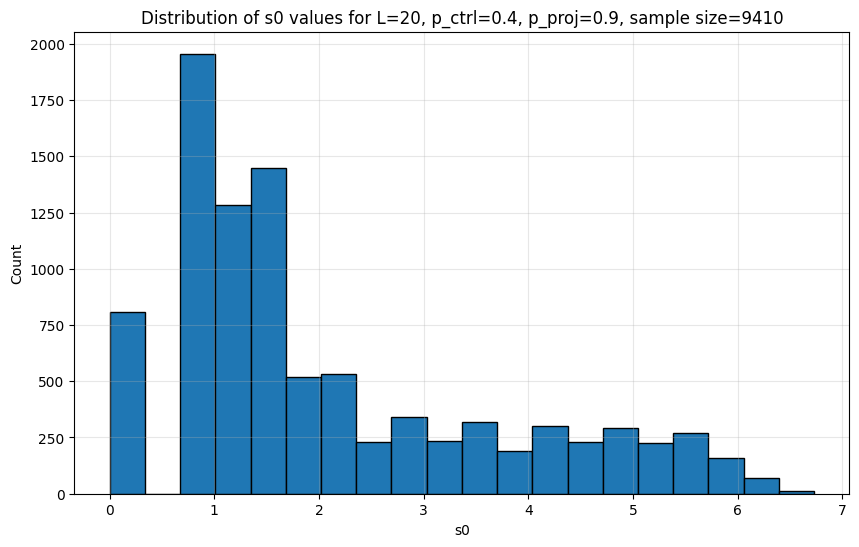

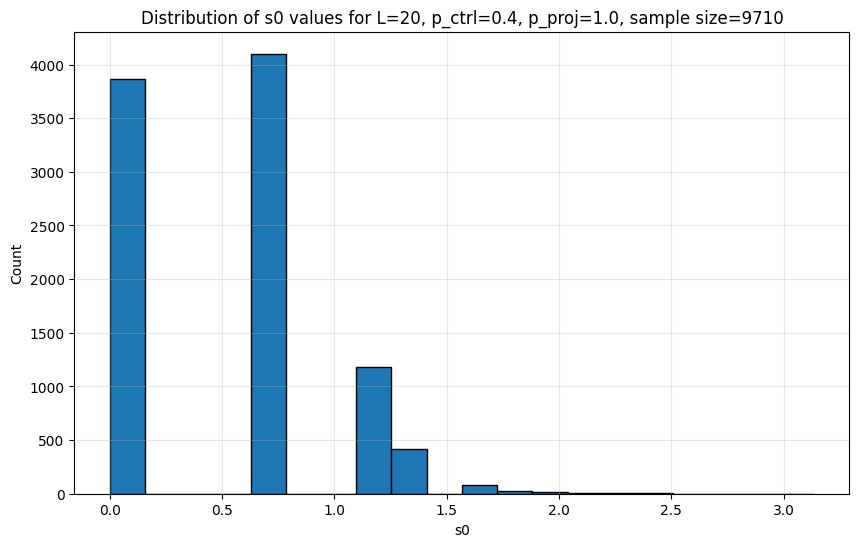

In [26]:
for key in s0_dict.keys():  
    plt.figure(figsize=(10,6))
    plt.hist(s0_dict[key], bins=20, edgecolor='black')
    plt.xlabel('s0')
    plt.ylabel('Count')
    plt.title(f'Distribution of s0 values for L={key[0]}, p_ctrl={key[1]}, p_proj={key[2]}, sample size={len(s0_dict[key])}')
    plt.grid(True, alpha=0.3)
plt.show()


In [12]:
len(min_sv_dict[(20,0.4,0.65)])

5

(20, 0.4, 0.5) 4
(20, 0.4, 0.55) 2
(20, 0.4, 0.6) 4
(20, 0.4, 0.65) 5
(20, 0.4, 0.7) 4
(20, 0.4, 0.75) 4
(20, 0.4, 0.8) 5
(20, 0.4, 0.85) 4


/scratch/ty296/CT_MPS_mini/read_hdf5_func.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(20, 0.4, 0.9) 2
(20, 0.4, 0.95) 8
(20, 0.4, 1.0) 10


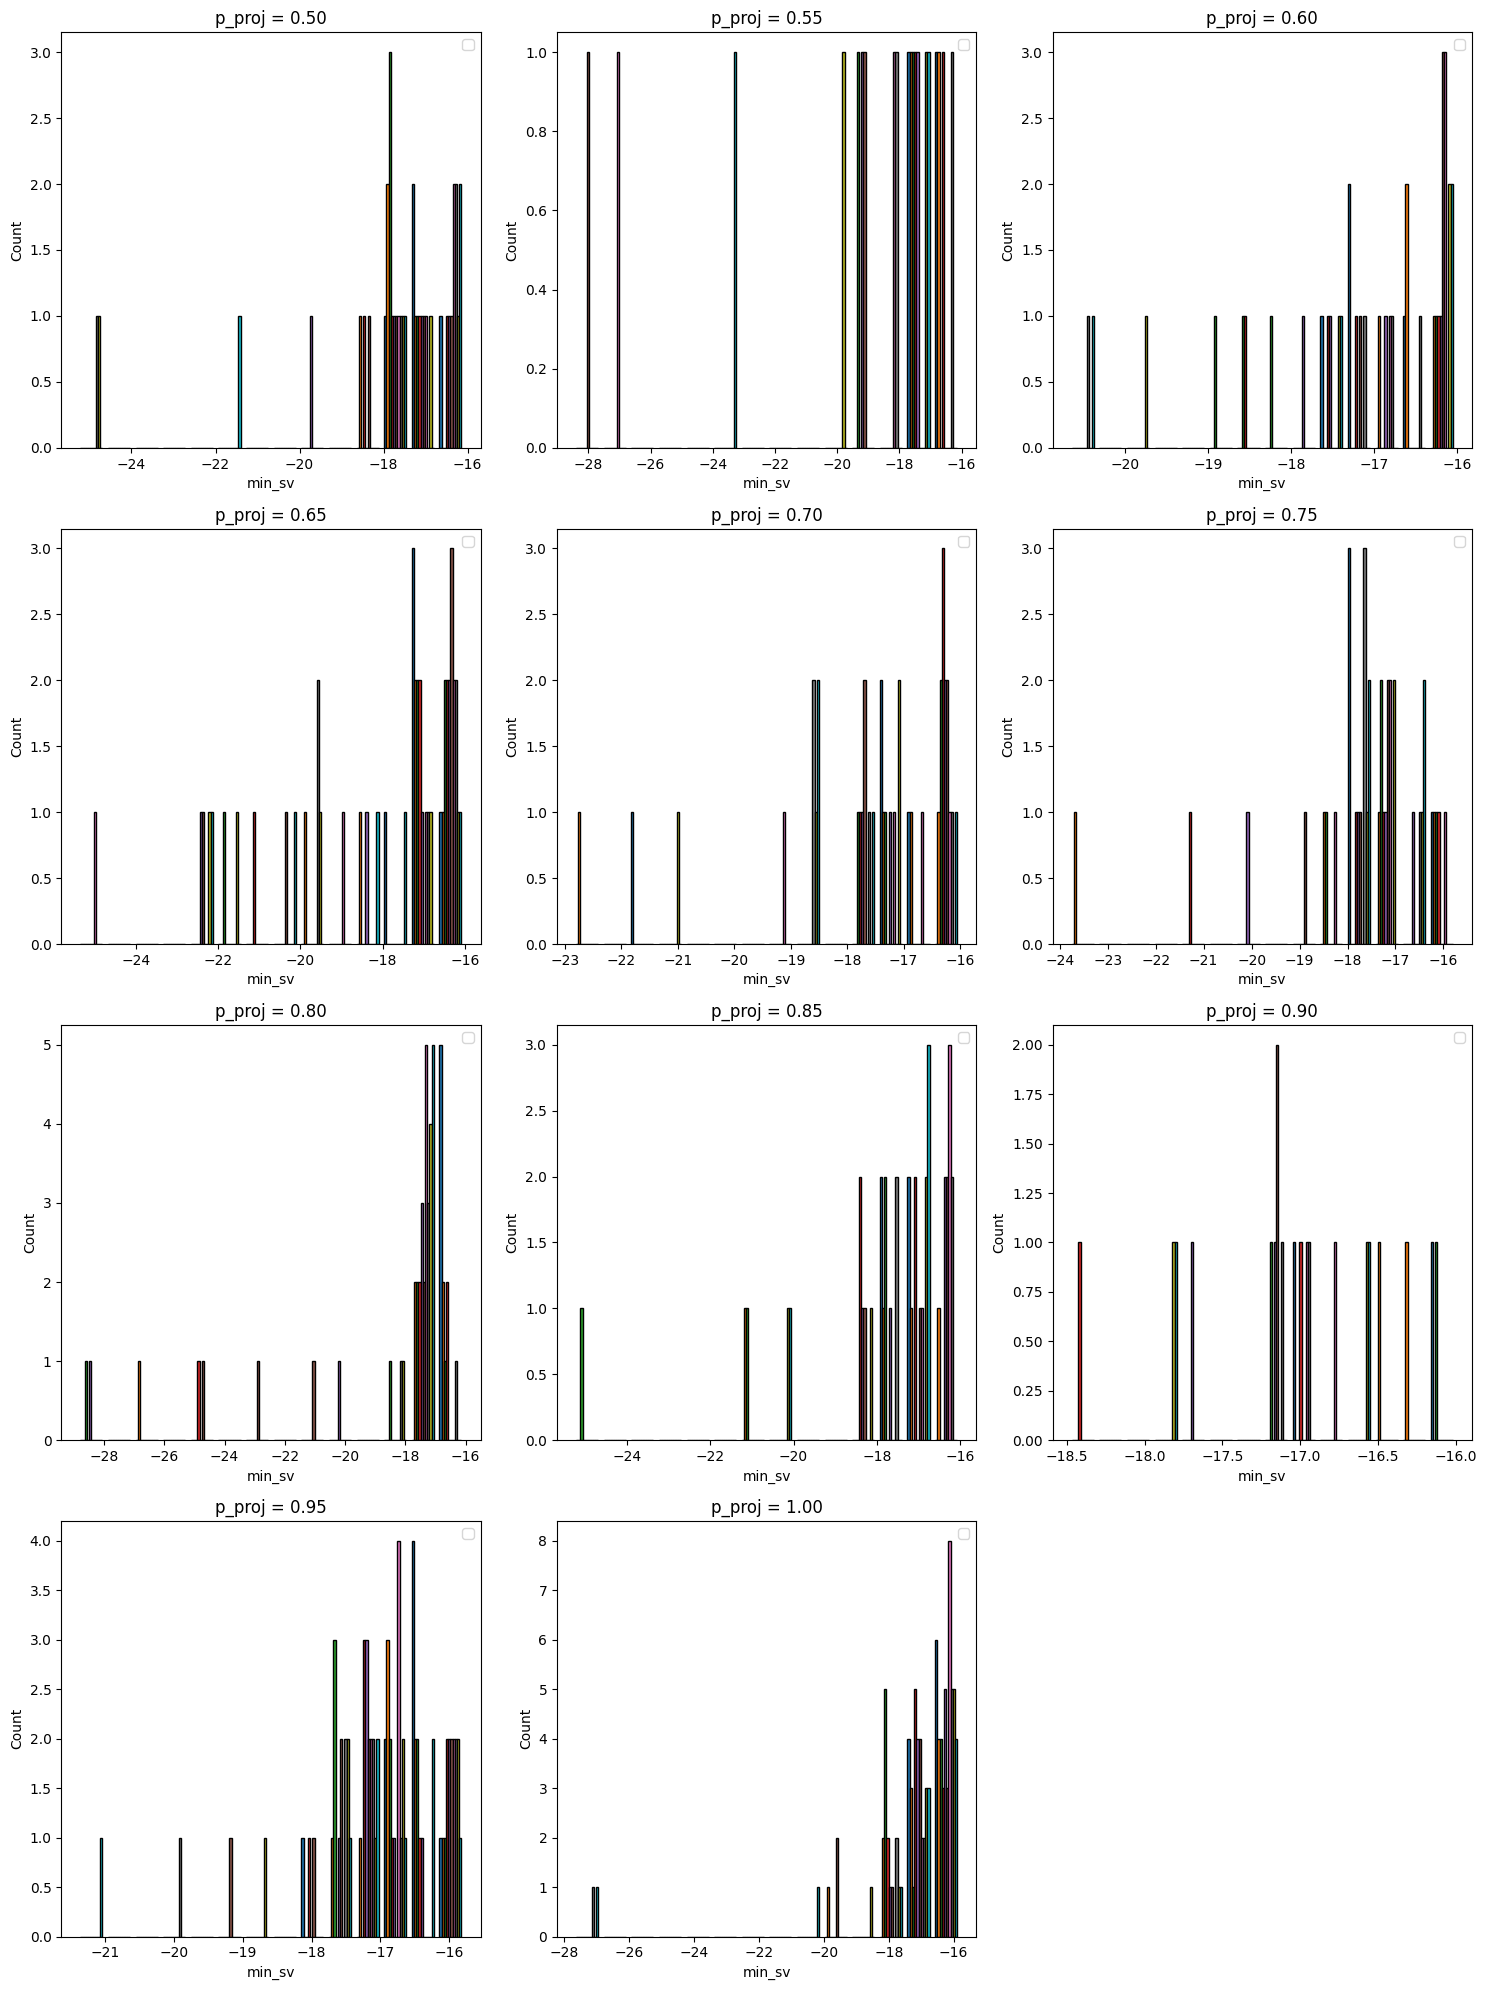

In [13]:
plot_distribution(min_sv_dict, x_label='min_sv', log_scale=True, n_bins=14)


(20, 0.4, 0.5) 938
(20, 0.4, 0.55) 945
(20, 0.4, 0.6) 936
(20, 0.4, 0.65) 844
(20, 0.4, 0.7) 929
(20, 0.4, 0.75) 892
(20, 0.4, 0.8) 900
(20, 0.4, 0.85) 927
(20, 0.4, 0.9) 941
(20, 0.4, 0.95) 944
(20, 0.4, 1.0) 971


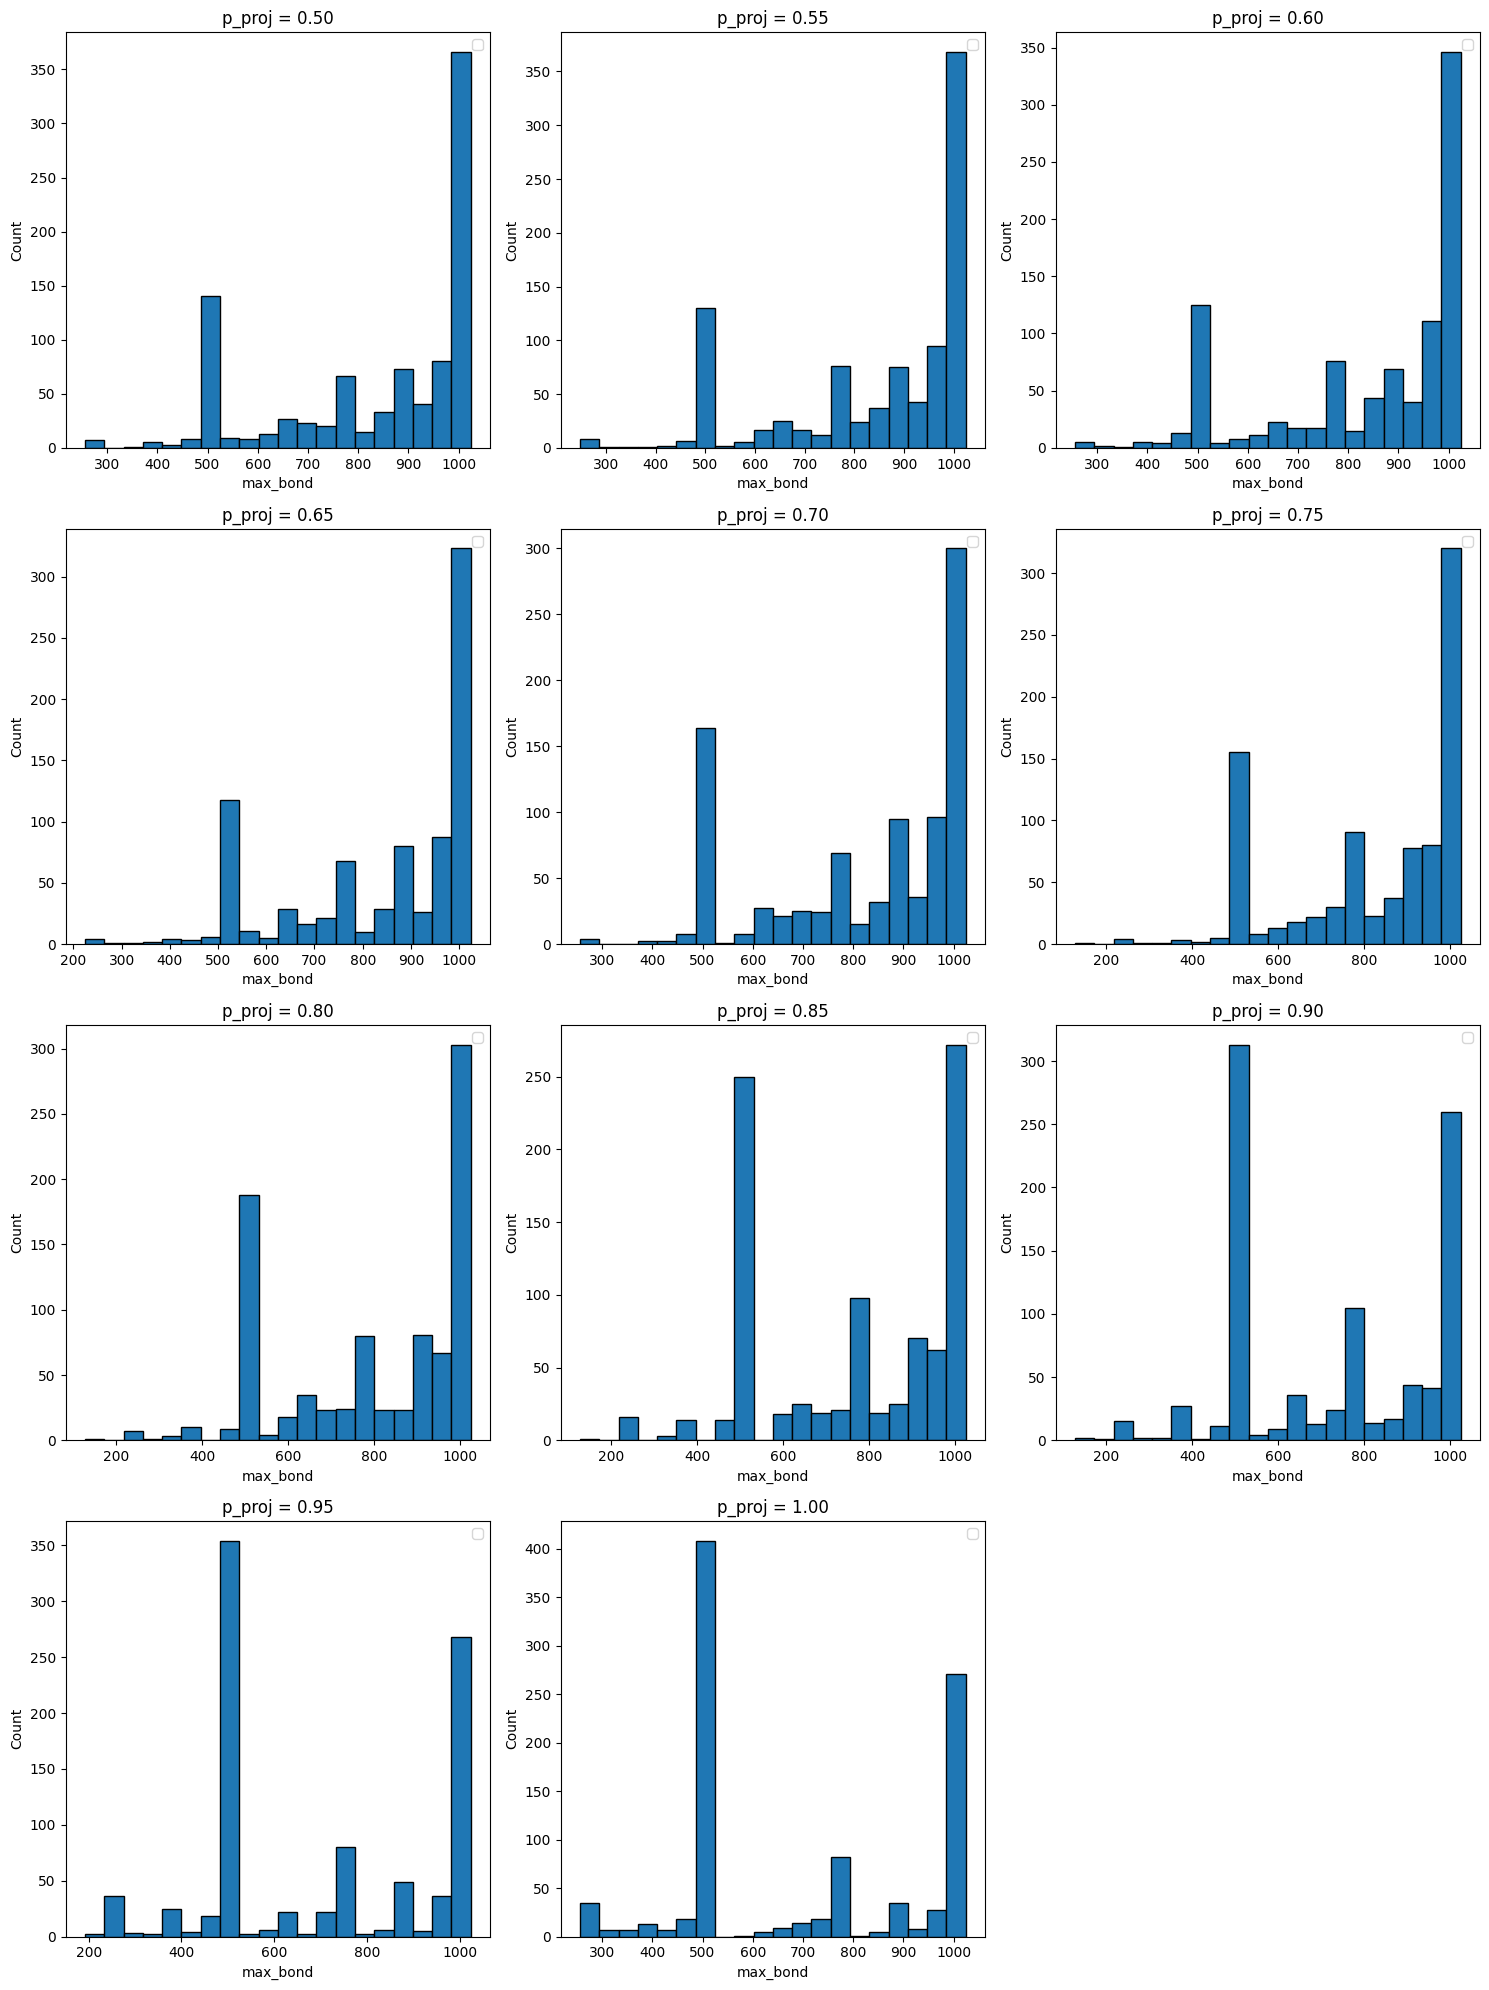

In [14]:
plot_distribution(maxbond_dict, x_label='max_bond')


In [15]:
len(entropy_dict)

11

(20, 0.4, 0.5) 4
(20, 0.4, 0.55) 2
(20, 0.4, 0.6) 4
(20, 0.4, 0.65) 5
(20, 0.4, 0.7) 4
(20, 0.4, 0.75) 4
(20, 0.4, 0.8) 5
(20, 0.4, 0.85) 4
(20, 0.4, 0.9) 2
(20, 0.4, 0.95) 8
(20, 0.4, 1.0) 10


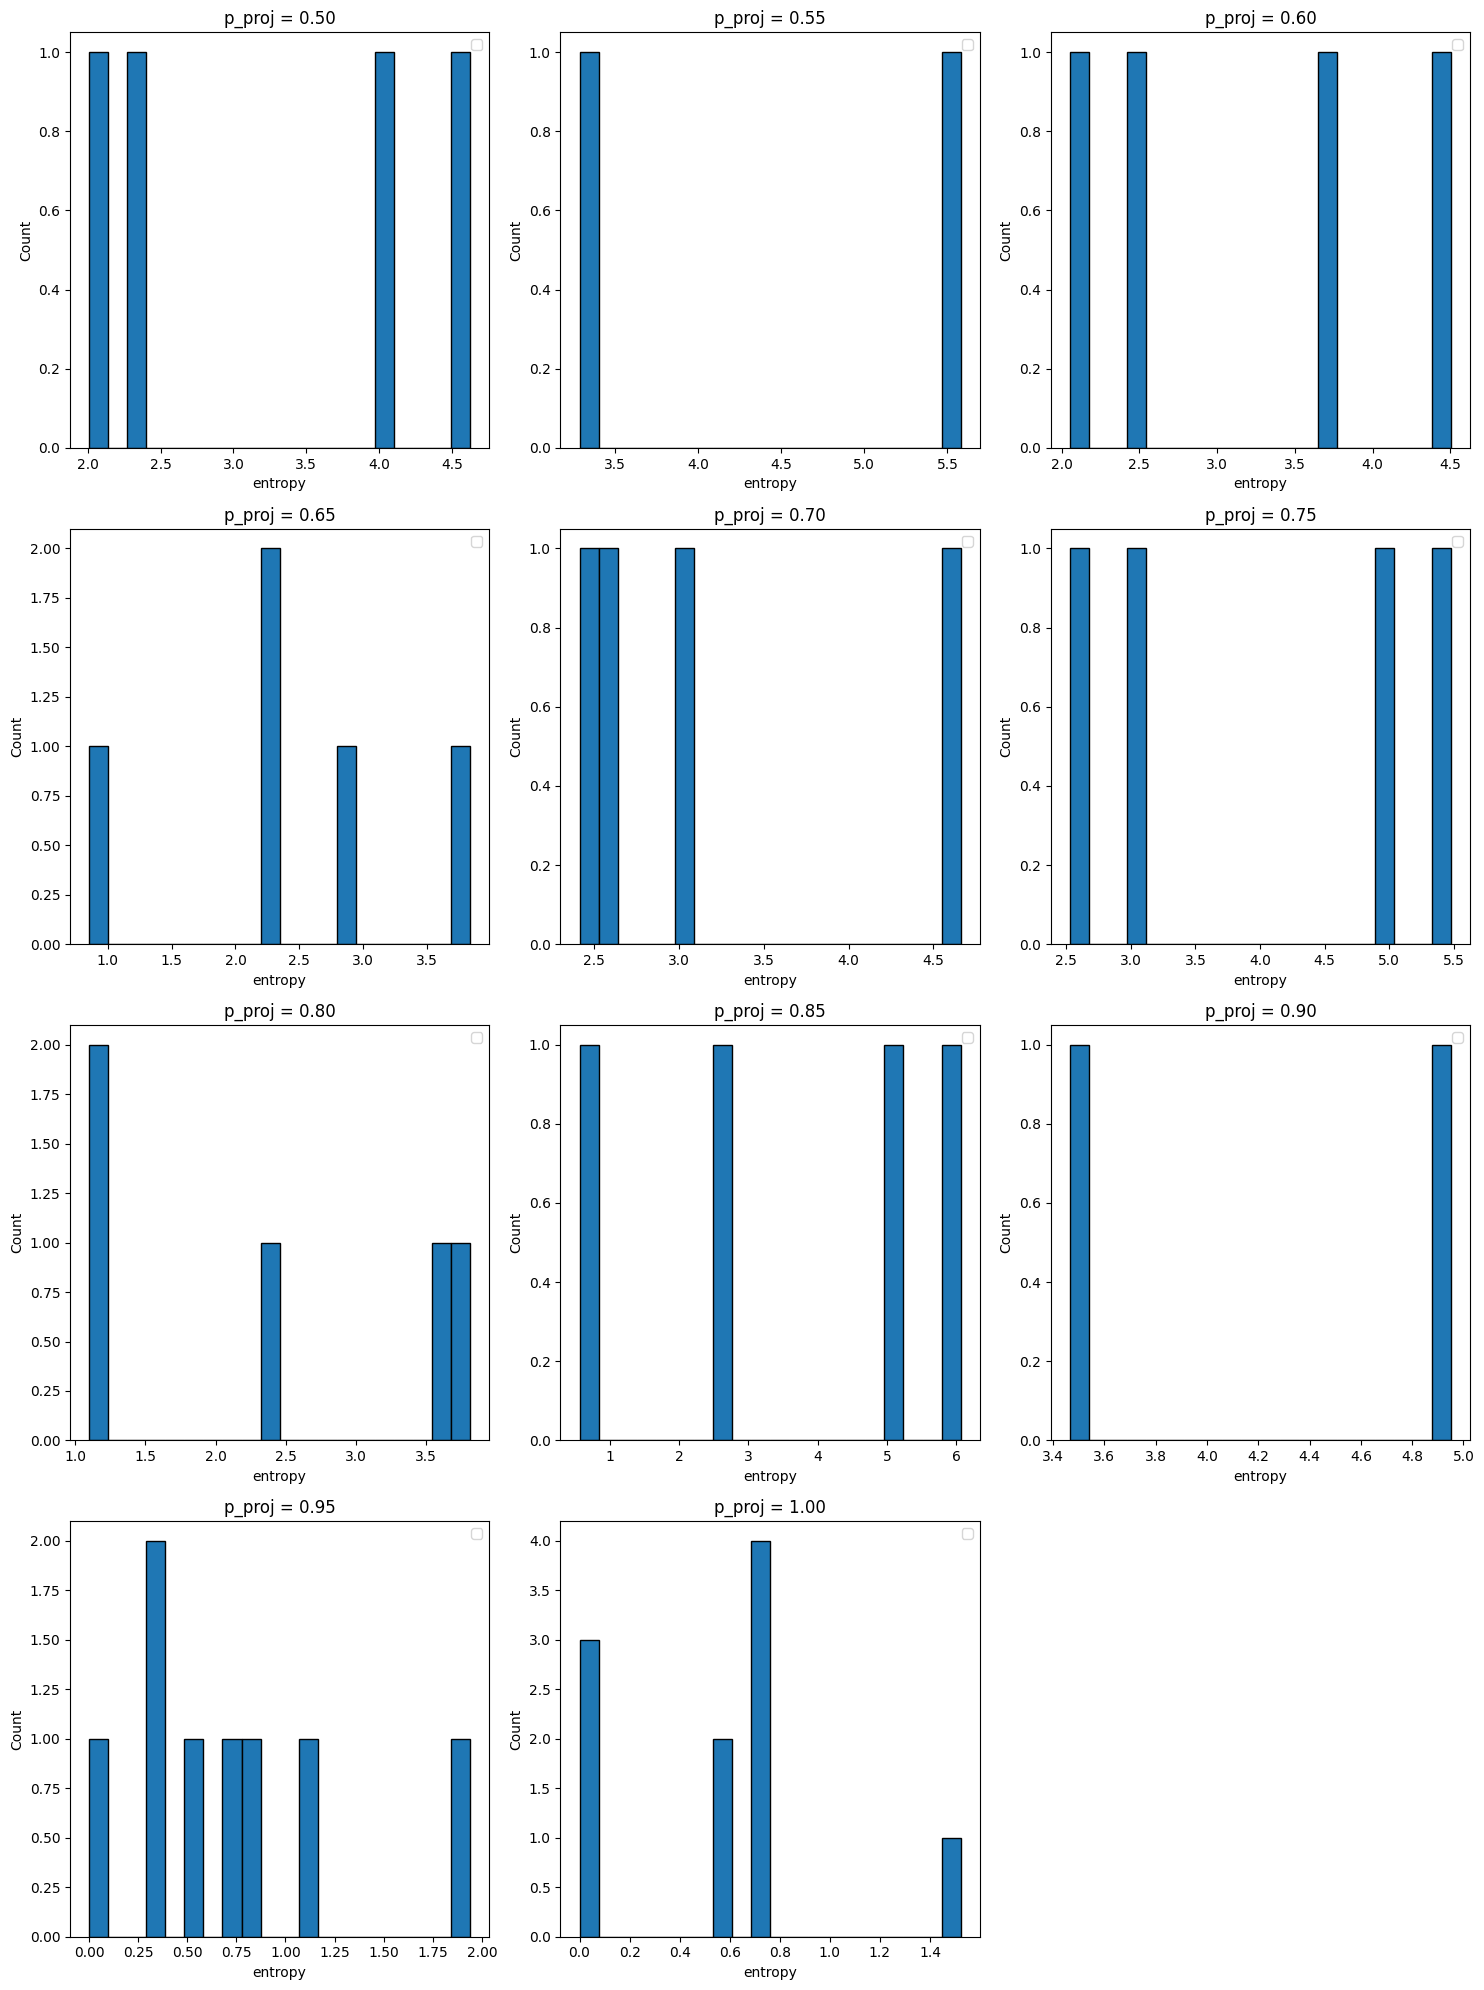

In [16]:
plot_distribution(entropy_dict, x_label='entropy')
